AR overlay using ArUco markers


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

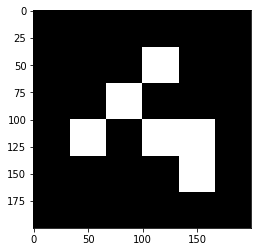

In [2]:
#Load the dictionary 
dictionary  = cv2.aruco.Dictionary_get(cv2.aruco.DICT_4X4_100)

tgtMarkerID = 14
# Generate the marker
markerImage = np.zeros((200,200),dtype=np.uint8)
markerImage = cv2.aruco.drawMarker(dictionary,tgtMarkerID,200,markerImage,1)

plt.imshow(markerImage,cmap='gray')
plt.show()

# Detection Markers


Input image shape is (3024, 2268, 3)


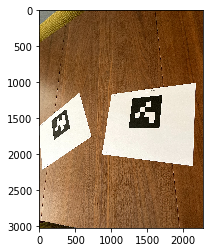

In [3]:

frame = cv2.imread("X:/arvr_exploration/images/aruco_overlay/IMG_4809.jpg")

frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)

#Load the dictionary that was used to generate the marker
dictionary = cv2.aruco.Dictionary_get(cv2.aruco.DICT_4X4_100)

#Initialize the detector parameters using the default values
parameters = cv2.aruco.DetectorParameters_create()

#Detect the marker in the image
markerCorners, markerIds, rejectedCandidates = cv2.aruco.detectMarkers(frame, dictionary, parameters = parameters)

print("Input image shape is", frame.shape)

detectedMarkerID = markerIds[0][0]

plt.imshow(frame)




In [4]:
markerIds


array([[14],
       [31]], dtype=int32)

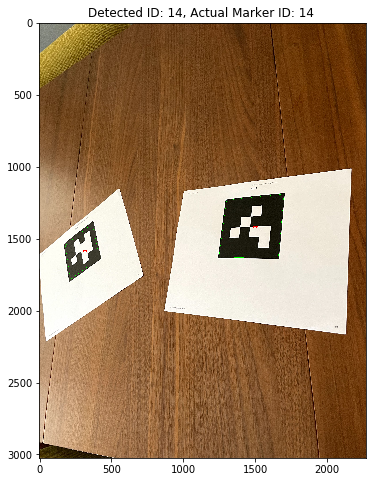

In [5]:
# Show detected corners

img_corners = np.copy(frame)
# img_corners = cv2.cvtColor(img_corners,cv2.COLOR_BGR2RGB)

cv2.aruco.drawDetectedMarkers(img_corners, markerCorners, markerIds);

# # print(img_corners.shape)
# for corner in markerCorners:
# #     print((pts.shape))

#     for i in range(0,4):
#         x = corner[0][i][0]
#         y = corner[0][i][1]
# #         print(x,y)
#         img2 = cv2.circle(img_corners, (x, y), 20, (255,0,0), 4)
        

#     #Add text to the image
# #     img2 = cv2.addText(img2,ids[0][0],(20,20),cv2.FONT_HERSHEY_SIMPLEX,1, (255, 0, 0))
#     #img2 = cv2.addText(img2,ids[0][0],(20,20),cv2.FONT_HERSHEY_SIMPLEX,1, (255, 0, 0))

figure(figsize=(12,8))    
# plt.imshow(cv2.cvtColor(img2,cv2.COLOR_BGR2RGB))
plt.imshow(img_corners)
plt.title('Detected ID: {}, Actual Marker ID: {} '.format(tgtMarkerID, detectedMarkerID))
plt.show()




In [6]:
print(markerCorners)


[array([[[1301., 1231.],
        [1698., 1189.],
        [1659., 1634.],
        [1247., 1628.]]], dtype=float32), array([[[ 182., 1545.],
        [ 369., 1394.],
        [ 419., 1633.],
        [ 217., 1782.]]], dtype=float32)]


In [7]:
# Detect pose from this data
# Load the camera calibration matrix
cameraMatrix = np.load("calibration_matrix.npy")
distCoeffs = np.load("distCoeffs.npy")

[rvecs, tvecs, objPts] = cv2.aruco.estimatePoseSingleMarkers(markerCorners, 1, cameraMatrix, distCoeffs);

# print("tvecs are: \n ", tvecs)
print("rvec is rodrigues rotation vector: \n ", np.rad2deg(rvecs))
print("objPts are: \n ", objPts)

dst,jacob = cv2.Rodrigues(rvecs[0][0])
#Convert the dcm to euler angles

print('\n dst=\n ', dst)
# print('\njacobian= \n',jacob)



rvec is rodrigues rotation vector: 
  [[[157.26669279   5.37621202 -48.03403376]]

 [[146.34732593 -36.69280631 -37.72682366]]]
objPts are: 
  [[[-0.5  0.5  0. ]]

 [[ 0.5  0.5  0. ]]

 [[ 0.5 -0.5  0. ]]

 [[-0.5 -0.5  0. ]]]

 dst=
  [[ 0.83051941  0.13922852 -0.53930783]
 [-0.01655289 -0.96165732 -0.27375391]
 [-0.55674367  0.23628504 -0.79637043]]


In [8]:
from scipy.spatial.transform import Rotation as R
r = R.from_dcm(dst)

print(np.rad2deg(r.as_euler('zyx')))
print(np.rad2deg(r.as_euler('ZYX')))


[ -9.51659104 -32.63653223 161.02949071]
[ -1.14179807  33.83089888 163.4742492 ]


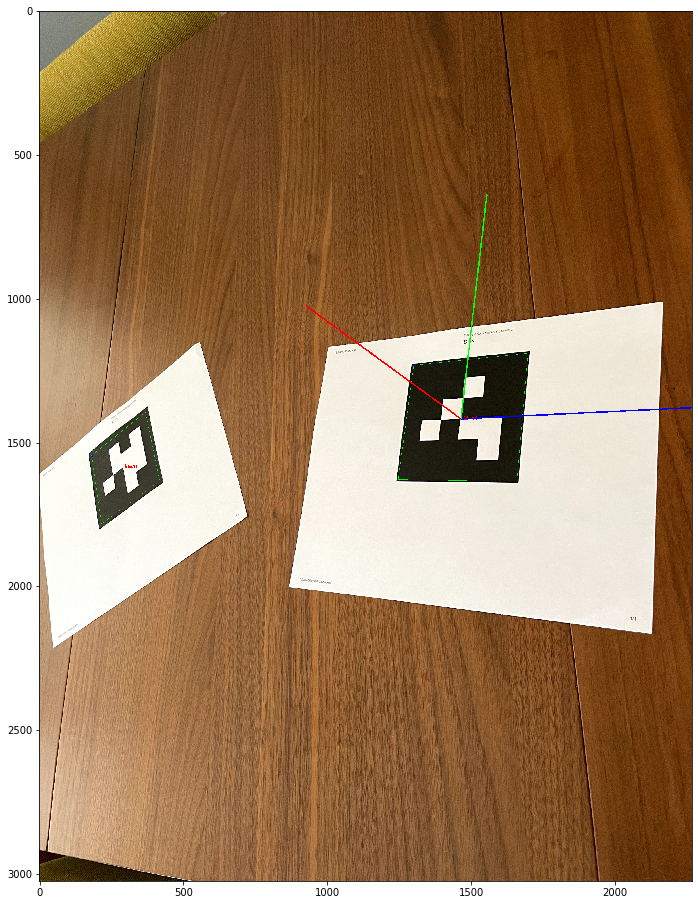

In [9]:
# Draw the markers
img_axis = np.copy(img_corners)

for i in range(0,1):
    rvec = rvecs[0][i];
    tvec = tvecs[0][i];
    cv2.aruco.drawAxis(img_axis, cameraMatrix, distCoeffs, rvec, tvec, 2);

figure(figsize=(12,16))    
# plt.imshow(cv2.cvtColor(img2,cv2.COLOR_BGR2RGB))
plt.imshow(img_axis)
plt.title('')
plt.show()
    
    

[[1301. 1231.]
 [1698. 1189.]
 [1659. 1634.]
 [1247. 1628.]]
[1270 1196]


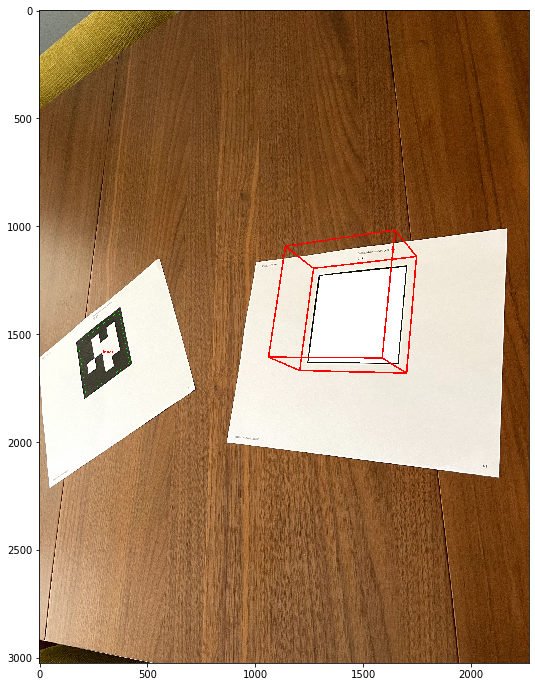

In [15]:
# Now that I know the pose of the camera, show a 3d model overlayed on the marker

img3 = np.copy(img_corners)

print(markerCorners[0][0])
# Hide the marker completely
img3 = cv2.fillPoly(img3,[markerCorners[0][0].astype(np.int)], color=(255,255,255))


# 0,0 is the center of the marker
xl  = 0.6
height = 0.6
model_pts = np.array([[-xl,xl,0],
                    [xl,xl,0],
                    [xl,-xl,0],
                    [-xl,-xl,0],
                    [-xl,xl,height],
                    [xl,xl,height],
                    [xl,-xl,height],
                    [-xl,-xl,height]],dtype=np.double)


# Project object pts to image coordinates 
imgpts2, _ = cv2.projectPoints(model_pts,
                               rvecs[0][0],tvecs[0][0],
                               cameraMatrix,distCoeffs)


imgpts2 = imgpts2.astype(np.int)
print(imgpts2[0][0])

# Draw lines
color = (255,0,0)
thickness = 6

for i in range(0,4):
    istart = i%4
    iend = (i+1)%4
    # Base of cube
    cv2.line(img3,tuple(imgpts2[istart][0]),tuple(imgpts2[iend][0]),color,thickness) 
    
    # Top part of cube
    cv2.line(img3,tuple(imgpts2[istart+4][0]),tuple(imgpts2[iend+4][0]),color,thickness) 

    # Plot connectors
    cv2.line(img3,tuple(imgpts2[istart][0]),tuple(imgpts2[istart+4][0]),color,thickness) 

    
figure(figsize=(16,12))
plt.imshow(img3)
plt.show()

# for i in range(0,model_pts.shape[0]):
# #     print(model_pts[i])
#     print(rvecs[0][0])


In [11]:
# #Show the image with marker removed
# img3 = np.copy(img_axis)

# print(markerCorners[0][0][0])
# print(markerCorners[0][0][2])
# img3 = cv2.rectangle(img3,tuple(markerCorners[0][0][0]),tuple(markerCorners[0][0][2]),(0,0,0),-2)


# # Draw the markers
# # img_axis = np.copy(img_corners)

# for i in range(0,1):
#     rvec = rvecs[0][i];
#     tvec = tvecs[0][i];
#     cv2.aruco.drawAxis(img3, cameraMatrix, distCoeffs, rvec, tvec, 1);

# figure(figsize=(12,16))    
# # plt.imshow(cv2.cvtColor(img2,cv2.COLOR_BGR2RGB))
# plt.imshow(img3)
# plt.title('')
# plt.show()



# # figure(figsize=(12,16))    
# # # plt.imshow(cv2.cvtColor(img2,cv2.COLOR_BGR2RGB))
# # plt.imshow(img3)
# # plt.title('')
# # plt.show()

